In [90]:
# TensorFlow and tf.keras
import os
import pathlib
from typing import Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import PIL.Image
import tensorflow as tf
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm


In [91]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np

model = ResNet50(weights="imagenet")


In [69]:
def load_images(
    base_folder, output_size: Optional[Tuple[int]] = None, nb_images: Optional[int] = None
):
    images_folder = pathlib.Path(base_folder)

    images_paths = list(images_folder.glob("**/*.jpg"))
    images_ids = list(map(lambda x: os.path.splitext(os.path.basename(x))[0], images_paths))[
        :nb_images
    ]

    images = []
    for img_path in tqdm(images_paths[:nb_images]):
        img = image.load_img(img_path, target_size=output_size)
        images.append(image.img_to_array(img))

    return images_ids, np.asarray(images)


In [56]:
def encode_dataset(
    images_folder, target_filename, model, output_size=None, nb_images=None, preprocess_input=None
):
    print("Loading images")
    images_ids, images = load_images(images_folder, output_size=output_size, nb_images=nb_images)

    print("Preprocessing images")
    if preprocess_input is not None:
        images = preprocess_input(images)

    print("Computing embeddings")
    features = model.predict(images)

    print("Saving embeddings")
    np.save(target_filename, features)

    print("Saving_ids")
    with open(os.path.splitext(target_filename)[0] + "_ids.txt", "w") as f:
        f.write("\n".join(images_ids))


In [71]:
encode_dataset(
    "../index",
    "./data/index_features.npy",
    model,
    preprocess_input=preprocess_input,
    output_size=(224, 224),
    nb_images=1000,
)

Loading images


100%|██████████| 1000/1000 [00:03<00:00, 272.06it/s]


Preprocessing images
Computing embeddings
Saving embeddings
Saving_ids


In [70]:
encode_dataset(
    "../test",
    "./data/test_features.npy",
    model,
    preprocess_input=preprocess_input,
    output_size=(224, 224),
    nb_images=300,
)


Loading images


100%|██████████| 300/300 [00:01<00:00, 279.18it/s]


Preprocessing images
Computing embeddings
Saving embeddings
Saving_ids


In [92]:
def find_best_neighbors(index_ids, query_ids, index_embeddings, query_embeddings):

    similarities = cosine_similarity(query_embeddings, index_embeddings)

    results = {"id": [], "images": []}

    for i, query_id in enumerate(query_ids):
        results["id"].append(query_id)
        results["images"].append(" ".join(index_ids[np.argsort(similarities[i])[-5:][::-1]]))

    return results


In [93]:
with open("./data/index_features_ids.txt", "r") as f:
    index_ids = np.asarray(f.read().split("\n"))
with open("./data/test_features_ids.txt", "r") as f:
    query_ids = np.asarray(f.read().split("\n"))

index_embeddings = np.load("./data/index_features.npy")
query_embeddings = np.load("./data/test_features.npy")

results = find_best_neighbors(index_ids, query_ids, index_embeddings, query_embeddings)


In [76]:
def get_path(folder, image_id):
    return os.path.join(folder, f"{image_id[0]}/{image_id[1]}/{image_id[2]}/{image_id}.jpg")

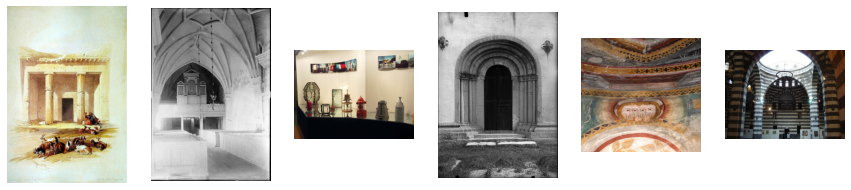

In [89]:
sample = 200

fig, axs = plt.subplots(1, 6, figsize=(15, 8))

img = image.load_img(get_path("../test", results["id"][sample]))
axs[0].imshow(img)
axs[0].set_axis_off()


images_ids = results["images"][sample].split(" ")
for i in range(5):
    img = image.load_img(get_path("../index", images_ids[i]))
    axs[i+1].imshow(img)
    axs[i+1].set_axis_off()


plt.show()
